In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from spikingjelly.activation_based import neuron, functional, surrogate, layer
from torch.utils.tensorboard import SummaryWriter
import os
import time
import argparse
from torch.cuda import amp
import sys
import datetime
from spikingjelly import visualizing


In [3]:
import numpy as np
np.int = int

In [36]:
class CSNN(nn.Module):
    def __init__(self, out_class=10, T=4):
        super(CSNN, self).__init__()
        self.T = T
        self.out_class = out_class
        self.layer1 = nn.Sequential(
            layer.Conv2d(1, 128, kernel_size=3,
                         padding=1, step_mode='s', bias=False),
            layer.BatchNorm2d(128, step_mode='s'),
        )
        self.layer2 = nn.Sequential(
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.MaxPool2d(kernel_size=2, stride=2),
            layer.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(128),
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            layer.Flatten(),
            layer.Dropout(p=0.5),
            layer.Linear(128*7*7, 1152),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.Dropout(p=0.5),
            layer.Linear(1152, 128),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.Linear(128, self.out_class),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m')
        )

        functional.set_step_mode(self.layer2, step_mode='m')
        functional.set_step_mode(self.layer3, step_mode='m')
        functional.set_backend(self, backend='cupy')

    def forward(self, x):
        # x = self.pe(x)
        x = self.layer1(x)
        x_step = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)
        # print(f"Shape after layer2: {x_step.shape}")
        out1 = self.layer2(x_step)
        # print(f"Shape after layer2: {out1.shape}")
        out2 = self.layer3(out1)
        return out2.mean(dim=0)

In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root='./dataset/fminist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True)

test_set = torchvision.datasets.FashionMNIST(
    root='./dataset/fminist/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True)

100%|██████████| 26.4M/26.4M [00:07<00:00, 3.73MB/s]


Extracting ./dataset/fminist/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./dataset/fminist/FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]


Extracting ./dataset/fminist/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./dataset/fminist/FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.01MB/s]


Extracting ./dataset/fminist/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./dataset/fminist/FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting ./dataset/fminist/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./dataset/fminist/FashionMNIST\raw



In [4]:
class CSNN(nn.Module):
    def __init__(self, T: int, channels: int, use_cupy=False):
        super().__init__()
        self.T = T

        self.conv_fc = nn.Sequential(
            layer.Conv2d(1, channels, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(channels),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),  # 14 * 14

            layer.Conv2d(channels, channels, kernel_size=3,
                         padding=1, bias=False),
            layer.BatchNorm2d(channels),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),  # 7 * 7

            layer.Flatten(),
            layer.Linear(channels * 7 * 7, channels * 4 * 4, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.Linear(channels * 4 * 4, 10, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

        if use_cupy:
            functional.set_backend(self, backend='cupy')

    def forward(self, x: torch.Tensor):
        # x.shape = [N, C, H, W]
        # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)
        x_seq = self.conv_fc(x_seq)
        fr = x_seq.mean(0)
        return fr

In [5]:
from torchinfo import summary
model = CSNN(T=2, channels=128, use_cupy=True)
summary(model, (256, 1, 28, 28), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CSNN                                     [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [2, 256, 1, 28, 28]       [2, 256, 10]              --
│    └─Conv2d: 2-1                       [2, 256, 1, 28, 28]       [2, 256, 128, 28, 28]     1,152
│    └─BatchNorm2d: 2-2                  [2, 256, 128, 28, 28]     [2, 256, 128, 28, 28]     256
│    └─IFNode: 2-3                       [2, 256, 128, 28, 28]     [2, 256, 128, 28, 28]     --
│    └─MaxPool2d: 2-4                    [2, 256, 128, 28, 28]     [2, 256, 128, 14, 14]     --
│    └─Conv2d: 2-5                       [2, 256, 128, 14, 14]     [2, 256, 128, 14, 14]     147,456
│    └─BatchNorm2d: 2-6                  [2, 256, 128, 14, 14]     [2, 256, 128, 14, 14]     256
│    └─IFNode: 2-7                       [2, 256, 128, 14, 14]     [2, 256, 128, 14, 14]     --
│    └─MaxPool2d: 2-8    

In [19]:
from ptflops import get_model_complexity_info
model = model.cuda()  # model on GPU


def input_constructor(input_res):
    return torch.randn(256, *input_res).to('cuda')  # input on GPU


macs, params = get_model_complexity_info(
    model,
    (1, 28, 28),
    input_constructor=input_constructor,
    as_strings=False,
    print_per_layer_stat=True,
    verbose=True
)

print(f"MACs: {macs/1e6:.2f} M")
print(f"FLOPs (≈ 2 × MACs): {macs * 2 / 1e6:.2f} MFLOPs")
print(f"Parameters: {params / 1e6:.2f} M")

CSNN(
  0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
  (conv_fc): Sequential(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (0): Conv2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (1): BatchNorm2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (2): IFNode(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=cupy
      (surrogate_function): ATan(0, 0.000% Params, 0.0 Mac, 0.000% MACs, alpha=2.0, spiking=True)
    )
    (3): MaxPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (4): Conv2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (5): BatchNorm2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 128, eps=1e-05,

In [ ]:
T =2
device ='cuda:0'
b =256
epochs =64
data_dir = './dataset/fminist/'
out_dir = './fmnist/'
resume = False
j=8
opt = 'sgd'
momentum =0.9
lr =0.1
channels =128
save_es = None


net = CSNN(T=T, channels=channels, use_cupy=True)

# print(net)

net.to(device=device)

train_data_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=b,
    shuffle=True,
    drop_last=True,
    num_workers=j,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=b,
    shuffle=True,
    drop_last=False,
    num_workers=j,
    pin_memory=True
)


scaler = None
# if amp:
    # scaler = amp.GradScaler()
functional.set_backend(net, 'cupy', instance=neuron.LIFNode)

start_epoch = 0
max_test_acc = -1

optimizer = None
if opt == 'sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
elif opt == 'adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
else:
    raise NotImplementedError(opt)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)


out_dir = os.path.join(out_dir, f'T{T}_b{b}_{opt}_lr{lr}_c{channels}')

if amp:
    out_dir += '_amp'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f'Mkdir {out_dir}.')

writer = SummaryWriter(out_dir, purge_step=start_epoch)
with open(os.path.join(out_dir, 'args.txt'), 'w', encoding='utf-8') as args_txt:
    # args_txt.write(str(args))
    args_txt.write('\n')
    args_txt.write(' '.join(sys.argv))

for epoch in range(start_epoch, epochs):
    start_time = time.time()
    net.train()
    # torch.cuda.empty_cache()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    for img, label in train_data_loader:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        label_onehot = F.one_hot(label, 10).float()

        if scaler is not None:
            with amp.autocast():
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        functional.reset_net(net)

    train_time = time.time()
    train_speed = train_samples / (train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    lr_scheduler.step()

    net.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for img, label in test_data_loader:
            img = img.to(device)
            label = label.to(device)
            label_onehot = F.one_hot(label, 10).float()
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)

            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(net)
    test_time = time.time()
    test_speed = test_samples / (test_time - train_time)
    test_loss /= test_samples
    test_acc /= test_samples
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_acc', test_acc, epoch)

    save_max = False
    if test_acc > max_test_acc:
        max_test_acc = test_acc
        save_max = True

    checkpoint = {
        'net': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'max_test_acc': max_test_acc
    }

    if save_max:
        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

    torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))

    print(out_dir)
    print(f'epoch = {epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}, max_test_acc ={max_test_acc: .4f}')
    print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (epochs - epoch))).strftime("%Y-%m-%d %H:%M:%S")}\n')

./fmnist/T2_b256_sgd_lr0.1_c128_amp
epoch = 0, train_loss = 0.0364, train_acc = 0.7398, test_loss = 0.0247, test_acc = 0.8393, max_test_acc = 0.8393
train speed = 279.5635 images/s, test speed = 634.1752 images/s
escape time = 2025-06-15 22:27:33

./fmnist/T2_b256_sgd_lr0.1_c128_amp
epoch = 1, train_loss = 0.0218, train_acc = 0.8494, test_loss = 0.0234, test_acc = 0.8096, max_test_acc = 0.8393
train speed = 275.7690 images/s, test speed = 647.2797 images/s
escape time = 2025-06-15 22:30:11

./fmnist/T2_b256_sgd_lr0.1_c128_amp
epoch = 2, train_loss = 0.0189, train_acc = 0.8691, test_loss = 0.0204, test_acc = 0.8729, max_test_acc = 0.8729
train speed = 275.9221 images/s, test speed = 643.1991 images/s
escape time = 2025-06-15 22:30:21

./fmnist/T2_b256_sgd_lr0.1_c128_amp
epoch = 3, train_loss = 0.0171, train_acc = 0.8833, test_loss = 0.0188, test_acc = 0.8687, max_test_acc = 0.8729
train speed = 275.6158 images/s, test speed = 642.4754 images/s
escape time = 2025-06-15 22:30:26

./fmnist

KeyboardInterrupt: 

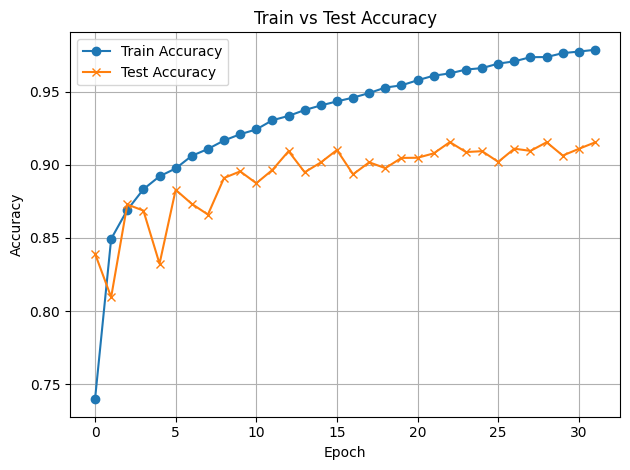

In [47]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Path to the log folder for your run
log_path = './fmnist/T2_b256_sgd_lr0.1_c128_amp'

event_acc = EventAccumulator(log_path)
event_acc.Reload()

train_acc_events = event_acc.Scalars('train_acc')
test_acc_events = event_acc.Scalars('test_acc')
train_loss_events = event_acc.Scalars('train_loss')
test_loss_events = event_acc.Scalars('test_loss')

train_epochs = [e.step for e in train_acc_events]
train_values = [e.value for e in train_acc_events]

test_epochs = [e.step for e in test_acc_events]
test_values = [e.value for e in test_acc_events]

plt.figure()
plt.plot(train_epochs, train_values, label='Train Accuracy', marker='o')
plt.plot(test_epochs, test_values, label='Test Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

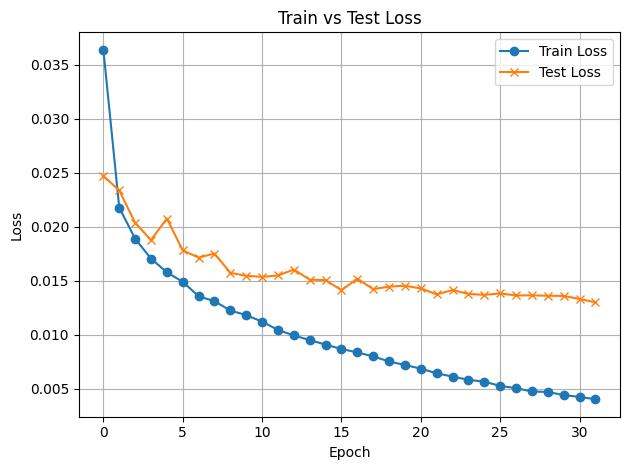

In [48]:
train_loss_events = event_acc.Scalars('train_loss')
test_loss_events = event_acc.Scalars('test_loss')

train_epochs = [e.step for e in train_loss_events]
train_values = [e.value for e in train_loss_events]

test_epochs = [e.step for e in test_loss_events]
test_values = [e.value for e in test_loss_events]

plt.figure()
plt.plot(train_epochs, train_values, label='Train Loss', marker='o')
plt.plot(test_epochs, test_values, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()